# Snowpark - Classification Heart Patient Data

Refactoring code from https://www.bmc.com/blogs/python-spark-machine-learning-classification into Snowpark and using data sets from Heart Disease Dataset: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
Implementing different classification algorithms

This first part creates the infrastructure that will be used by the Streamlit App

Carlos Carrero - Dec 2022

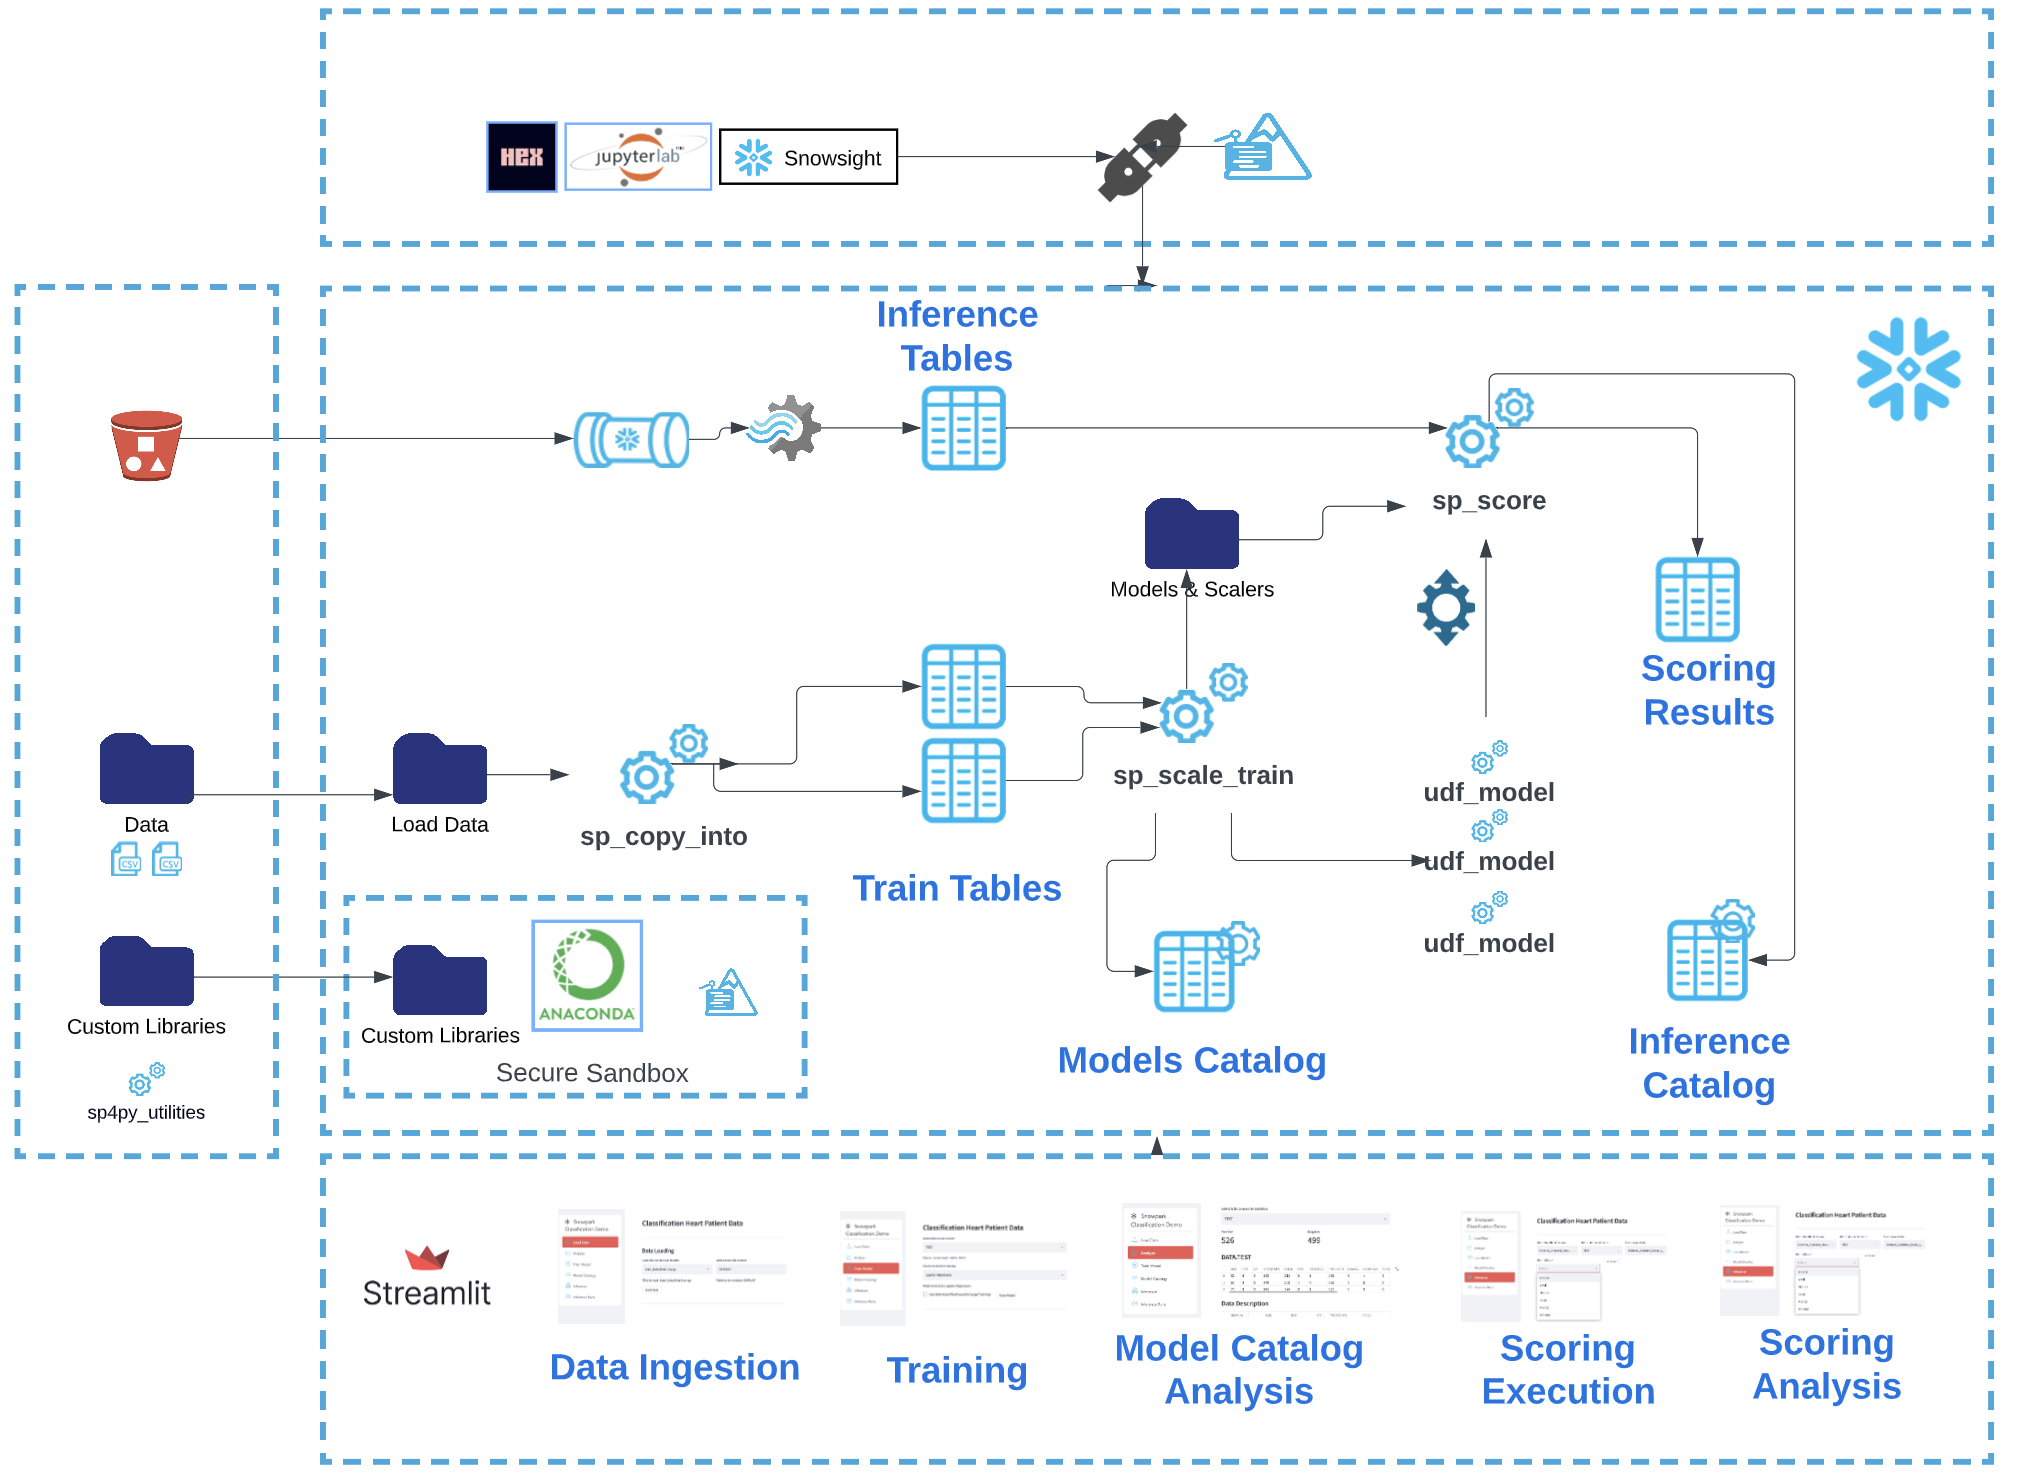

In [4]:
from IPython.display import Image, display
display(Image(filename='images/diagram.png', embed=True))

## Database, Tables, UDFs and Stored Procedure Definition
Also create Stored Procedures and UDFs to fully automate the training and inference process outside the Notebook

Scaler examples  and utilities taken from: https://github.com/snowflakecorp/sp4py_utilities/blob/main/sp4py_utilities_demo_training_scoring.ipynb


In [5]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

import pandas as pd
import json

TODO:  
Collect the credentials and then last in the notebook save it as creds.json so we can set the correct DB in it (we are creating the DB in this notebook and the Streamlit app is depended on the DB in creds.json)

In [6]:
with open('creds.json') as f:
    connection_parameters = json.load(f) 

In [7]:
session = Session.builder.configs(connection_parameters).create()

#### Next cell will create or replace a database called HEART_DB. Do not execute it if you have a database with that name. Rename it as needed

In [8]:
session.sql("CREATE OR REPLACE WAREHOUSE HOL_WH WITH WAREHOUSE_SIZE='X-SMALL'").collect()
session.sql("CREATE OR REPLACE DATABASE HEART_DB").collect()
session.sql("create or replace schema heart_db.data").collect()
session.sql("create or replace schema heart_db.output").collect()
session.sql("create or replace schema heart_db.internal").collect()

[Row(status='Schema INTERNAL successfully created.')]

In [9]:
session.sql('select current_warehouse(), current_database(), current_schema(), current_user(), current_role()').collect()


[Row(CURRENT_WAREHOUSE()='HOL_WH', CURRENT_DATABASE()='HEART_DB', CURRENT_SCHEMA()='INTERNAL', CURRENT_USER()='JOHN', CURRENT_ROLE()='ACCOUNTADMIN')]

Create staging areas needed

In [10]:
session.sql("create or replace stage internal.load_data").collect()
session.sql("create or replace stage internal.models").collect()

session.sql("create or replace stage internal.procedures").collect()
session.sql("create or replace stage internal.custom_packages").collect()

session.sql("create or replace sequence seq_model_01 start = 1 increment = 1").collect()
session.sql("create or replace sequence seq_inference_01 start = 1 increment = 1").collect()

[Row(status='Sequence SEQ_INFERENCE_01 successfully created.')]

We have unloaded the libraries from https://github.com/snowflakecorp/sp4py_utilities/blob/main/sp4py_utilities_demo_training_scoring.ipynb and it will be uploaded to custom_packages staging area to be used by stored procedures

In [11]:
#! unzip sp4py_utilities.zip

In [12]:
#session.clear_imports()
#session.clear_packages()
import sys
sys.path.insert(0, 'preprocessing')

import sp4py_utilities.preprocessing as pp

In [13]:
session.file.put('sp4py_utilities.zip', 'internal.custom_packages')
session.add_import("@internal.custom_packages/sp4py_utilities.zip")  

heart_1.csv and heart_2.csv are a subset of the heart.csv file. We can use those for testing

In [14]:
#session.sql("use schema heart_db.internal").collect()
session.use_schema("heart_db.internal")

session.file.put('data/heart.csv', 'internal.LOAD_DATA')
session.file.put('data/heart_1.csv', 'internal.LOAD_DATA')
session.file.put('data/heart_2.csv', 'internal.LOAD_DATA')

[PutResult(source='heart_2.csv', target='heart_2.csv.gz', source_size=8419, target_size=2016, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

Define two internal tables. One for storing data aboult each model generated and other for storing scoring results. This could be hybrid tables once it will be released.

In [15]:
schema_log=T.StructType([T.StructField("date", T.TimestampType()),
                     T.StructField("class_method", T.StringType()),
                     T.StructField("model_name", T.StringType()),
                     T.StructField("data_training", T.StringType()),
                     T.StructField("class_report", T.VariantType()),
                     T.StructField("TN", T.IntegerType()),
                     T.StructField("FP", T.IntegerType()),
                     T.StructField("FN", T.IntegerType()),
                     T.StructField("TP", T.IntegerType())
])

log_df = session.create_dataframe([],schema=schema_log)
log_df.write.mode('overwrite').save_as_table('internal.Models_Catalog')

schema_inference=T.StructType([T.StructField("date", T.TimestampType()),
                     T.StructField("model_name", T.StringType()),
                     T.StructField("source_table", T.StringType()),
                     T.StructField("target_table", T.StringType()),
                     T.StructField("accuracy", T.FloatType()),
                     T.StructField("precision", T.FloatType()),
                     T.StructField("recall", T.FloatType()),
                     T.StructField("f1_score", T.FloatType()),
                     T.StructField("TN", T.IntegerType()),
                     T.StructField("FP", T.IntegerType()),
                     T.StructField("FN", T.IntegerType()),
                     T.StructField("TP", T.IntegerType()),
                     T.StructField("Time_Total", T.FloatType()),
                     T.StructField("Time_Scoring", T.FloatType())
])

inference_df = session.create_dataframe([],schema=schema_inference)
inference_df.write.mode('overwrite').save_as_table('internal.Inference_Runs')

VARIANT data type is used to get the training results output. This view will simplify the query

In [16]:
session.sql("create or replace view heart_db.internal.accuracy_sum_v as select DATE, model_name, data_training,\
        class_report:accuracy as accuracy from MODELS_CATALOG;").collect()


cmd = """create or replace view internal.class_report_sumary_v as\
            select model_name,  data_training,\
            class_report:"0"."f1-score" neg_f1_score,\
            class_report:"0"."precision" neg_precision,\
            class_report:"0"."recall" neg_recall,\
            class_report:"1"."f1-score" pos_f1_score,\
            class_report:"1"."precision" pos_precision,\
            class_report:"1"."recall" pos_recall,\
            class_report:"accuracy" accuracy,\
            TN, FP, FN, TP  from internal.models_catalog"""
session.sql(cmd).collect()

session.sql("create or replace view heart_db.internal.data_training_v as select model_name, data_training from MODELS_CATALOG").collect()

[Row(status='View DATA_TRAINING_V successfully created.')]

Create a table that will be used by Streamlit with the models available for training

In [17]:
schema_model = T.StructType([T.StructField("model_name", T.StringType())])

df_models_table = session.create_dataframe([['Logistic Regression'],
                         ['Naive Bayes'], 
                         ['Random Forest Classifier'], 
                         ['DecisionTreeClassifier'],
                         ['Support Vector Classifier'],
                         ['Extreme Gradient Boost'],
                         ['K_NeighborsClassifier']], schema=schema_model)

df_models_table.write.mode("overwrite").save_as_table("internal.MODELS")

### Stored Procedures and UDFs Definition

Define a Store Procedure to copy data into a table from a staging area

In [18]:
def copy_into (session: Session, file_name: str, table_name: str) -> str:
    
    import snowflake.snowpark.types as T

    schema_heart2=T.StructType([T.StructField("age", T.IntegerType()),
                     T.StructField("sex", T.IntegerType()),
                     T.StructField("cp", T.IntegerType()),
                     T.StructField("trestbps", T.DecimalType()),
                     T.StructField("chol", T.IntegerType()),
                     T.StructField("fbs", T.DecimalType()),
                     T.StructField("restecg", T.DecimalType()),
                     T.StructField("thalach", T.DecimalType()),
                     T.StructField("exang", T.DecimalType()),
                     T.StructField("oldpeak", T.DecimalType()),
                     T.StructField("slope", T.DecimalType()),
                     T.StructField("ca", T.DecimalType()),
                     T.StructField("thal", T.IntegerType()),
                     T.StructField("target", T.IntegerType())
    ])

    table_name = "DATA." + table_name

    load_df2 = session.read\
        .option("FIELD_DELIMITER", ',')\
        .option("SKIP_HEADER", 1)\
        .option("ON_ERROR", "CONTINUE")\
        .schema(schema_heart2).csv(file_name)\
        .copy_into_table(table_name)

    return load_df2

In [19]:
#session.sql("use schema heart_db.internal").collect()
#session.sql("use warehouse HOL_WH").collect()
session.use_schema("heart_db.internal")
session.use_warehouse("HOL_WH")

session.sproc.register(
    func=copy_into,
    name="copy_into",
    packages=['snowflake-snowpark-python'],
    is_permanent=True,
    stage_location="@internal.procedures",
    replace=True)

We need to save into a stage the model and the scaler used for the model. Defining this generic function

In [20]:
import io
import joblib
import os

def save_file_to_stage(session, obj, stage, name):
    model_output_dir = '/tmp'
    model_file = os.path.join(model_output_dir, name)
    joblib.dump(obj, model_file)
    session.file.put(model_file, stage,overwrite=True, auto_compress = False )


Function to deploy a trained model as a UDF, used by the training stored procedure


In [21]:
# Function to deploy a trained model as a UDF, used by the training stored procedure
#def create_udf(model, udf_name, snf_session):
def create_udf(snf_session, udf_name, model, input_cols, stage_loc, py_packages):
    # Deploy a Batch API UDF, see example 9 and forward at https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/_autosummary/snowflake.snowpark.udf.html#snowflake.snowpark.udf.UDFRegistration
    @F.udf(name=udf_name, is_permanent=True, stage_location=stage_loc, max_batch_size=1000, packages=py_packages, replace=True, session=snf_session)
    def predict(ds: T.PandasSeries[dict]) -> T.PandasSeries[float]:
        df = pd.io.json.json_normalize(ds)[input_cols]
        prediction = model.predict(df)
        return prediction

Two functions used to log training and scoring information

In [22]:
def log_training(session, class_method, model_name, clone_table_name, class_report, TN, FP, FN, TP):
    import datetime
    import json

    dt = datetime.datetime.now()
    dt_str = str(dt)

    cmd = "INSERT INTO INTERNAL.MODELS_CATALOG (select '%s', '%s', '%s', '%s', PARSE_JSON('%s'), '%s','%s','%s','%s')" %\
        (dt_str, class_method, model_name, clone_table_name, json.dumps(class_report),\
         TN, FP, FN, TP)

    print (cmd) 
    
    session.sql(cmd).collect()


def log_inference (session, model_name, source_table, target_table, accuracy, precision, recall, 
                            f1_score, TN, FP, FN, TP, time_total, time_inference):
    import datetime

    dt = datetime.datetime.now()
    date = str(dt)

    cmd = "INSERT INTO INTERNAL.INFERENCE_RUNS VALUES ('%s', '%s', '%s', '%s', %f, %f, %f, %f, %f, %f, %f, %f, %d, %d )" %\
         (date, model_name, source_table, target_table, accuracy, precision, recall, f1_score, TN, FP, FN, TP, time_total, time_inference)

    session.sql(cmd).collect()

def log_inference_snp(model_name, source_table, target_table, metrics_df, time_total, time_inference):

    lg_df = metrics_df.with_columns(["date", "model_name", "source_table", "target_table", "Time_Total", "Time_Scoring"]
                                    , [F.current_timestamp(), F.lit(model_name), F.lit(source_table), F.lit(target_table), F.lit(time_total), F.lit(time_inference)])
      
    lg_df.write.save_as_table("INTERNAL.INFERENCE_RUNS", mode="append", column_order="name")


#### Training

The training function call the scaler and it is stored within the models staging area so it can be used later by the scoring procedure

In [23]:
# Separate pre-procesiong and training so we add more flexibility

def sf_scaler(session, table_name, stage, model_name, schema):
    import sp4py_utilities.preprocessing as pp

    clone_table_name = table_name + "_CLONE_" + model_name
    session.sql("create TABLE %s clone %s "%(clone_table_name, table_name)).collect()
    
    df_sf = session.table(clone_table_name)

    if schema == 1:
        df_sf = df_sf.with_column('target', 
                F.iff(F.col('thal').in_(F.lit(3),F.lit(7)), 
                    F.lit(0), 
                    F.lit(1)))

    target_sf_df = df_sf.select(F.col('target'))
    features_sf_df = df_sf.drop(F.col('thal')).drop(F.col('last')).drop(F.col('target'))
    
    features_column_names = features_sf_df.columns

    scaler_input_cols = features_sf_df.columns
    scaler_output_cols = ["SC_"+f for f in features_sf_df.columns]  

    ss = pp.StandardScaler(input_cols=scaler_input_cols, output_cols=scaler_output_cols)
    ss.fit(features_sf_df)

    scaler_name = model_name + ".scaler"
    save_file_to_stage(session, ss, stage, scaler_name)

    ss_features_sf_df = ss.transform(features_sf_df)

    ss_features_sf_df = ss_features_sf_df.select([*scaler_output_cols])

    return ss_features_sf_df, target_sf_df, clone_table_name


def sf_train(session, class_method, ss_features_sf_df, target_sf_df, stage, model_name, clone_table_name):

    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier

    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
    from sklearn.model_selection import train_test_split
    from datetime import datetime
    import json
    
    stage_loc = 'internal.procedures'
    py_packages = ['pandas']

    #Until now, we have ust used DataFrames. Now we convert to pandas to train the model: 
    target_df = target_sf_df.to_pandas()
    features_df = ss_features_sf_df.to_pandas()

    x_train, x_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.20, random_state=0)

    if class_method == "Logistic Regression":
        model = LogisticRegression()
        py_packages.append('scikit-learn')
    elif class_method == "Naive Bayes":
        model = GaussianNB()
        py_packages.append('scikit-learn')
    elif class_method == "Random Forest Classifier":
        model = RandomForestClassifier(n_estimators=20, random_state=12, max_depth=5)
        py_packages.append('scikit-learn')
    elif class_method == "Extreme Gradient Boost":
        model = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
        py_packages.append('xgboost')
    elif class_method == "K_NeighborsClassifier":
        model = KNeighborsClassifier (n_neighbors=10)
        py_packages.append('scikit-learn')
    elif class_method == "Support Vector Classifier":
        model = SVC(kernel='rbf', C=2)
        py_packages.append('scikit-learn')
    elif class_method == "DecisionTreeClassifier":
        model = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=6)
        py_packages.append('scikit-learn')

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    print (cnf_matrix)
    TN = cnf_matrix[0][0]
    FP = cnf_matrix[0][1]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]

    acc_score = accuracy_score (y_test, y_pred)

    class_report = classification_report (y_test, y_pred, output_dict=True)
    acc_score = class_report["accuracy"] * 100

    save_file_to_stage(session, model, stage, model_name)

    #create_udf(model, model_name, session)
    input_cols = ss_features_sf_df.columns
    create_udf(session, model_name, model, input_cols, stage_loc, py_packages)

    log_training(session, class_method, model_name, clone_table_name, class_report, TN, FP, FN, TP)

    ret_dict = {"Model": model_name,
                "conf matrix:": cnf_matrix.tolist(), 
                "accuracy score:": acc_score,
                "class_report": class_report} #""" % (model_name, cnf_matrix, acc_score, class_report)
    
    #print (value)

    return ret_dict #{"input_cols":input_cols}# json.dumps(value)
            


def sf_scaler_train(session: Session, class_method: str, table_name: str,
         stage: str, model_name: str, schema: str) -> dict:
    
    # Get the value of the first row and the first column
    seq = str(session.sql("select seq_model_01.nextval").collect()[0][0])
    #seq = str(seq[0]).replace("Row(NEXTVAL=","" ).replace(")", "")

    model_name = model_name + "_" + seq

    print (model_name)
    ss_features_sf_df, target_sf_df, clone_table_name = sf_scaler(session, table_name, stage, model_name, schema)
    result = sf_train(session, class_method, ss_features_sf_df, target_sf_df, stage, model_name, clone_table_name)

    return result


In [24]:
session.sproc.register(
    func=sf_scaler_train,
    name="sf_scaler_train",
    packages=['snowflake-snowpark-python','scikit-learn','joblib','xgboost'],
    is_permanent=True,
    stage_location="@internal.procedures",
    replace=True)

#### Scoring

Loads the scaler previously created and call the UDF that was already created by the training stored procedure

In [25]:
# Define functions to calculate metrics
def metrics_score (df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    tn = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 0)]['COUNT'])
    fp = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 1)]['COUNT'])
    fn = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 0)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    accuracy = (tp+tn) / (tp+tn+fn+fp)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1_score = (2*precision*recall) / (precision+recall)

    return accuracy, precision, recall, f1_score, tn, fp, fn, tp

# Function that calculates the metrics using Snowpark ie SQL
def metrics_score_snp(df, y_true, y_pred):
    return df.group_by([y_true, y_pred]).count()\
                .with_column("type", F.when((F.col(y_true) == 0) & (F.col(y_pred) == 0), "tn")\
                                    .when((F.col(y_true) == 0) & (F.col(y_pred) == 1), "fp")\
                                    .when((F.col(y_true) == 1) & (F.col(y_pred) == 0), "fn")\
                                    .when((F.col(y_true) == 1) & (F.col(y_pred) == 1), "tp"))\
                .select(["TYPE", "COUNT"]).pivot("TYPE", ['tn', 'tp', 'fn', 'fp']).sum("COUNT")\
                .select(F.col("'tp'").as_("tp"), F.col("'tn'").as_("tn"), F.col("'fn'").as_("fn"), F.col("'fp'").as_("fp"))\
                .with_columns(["accuracy", "precision", "recall"],
                             [((F.col("tp") + F.col("tn")) / (F.col("tp") + F.col("tn") + F.col("fn") + F.col("fp")))
                             , (F.col("tp") / (F.col("tp") + F.col("fp")))
                              ,(F.col("tp") / (F.col("tp") + F.col("fn")))])\
                .with_column("f1_score", (F.lit(2)*F.col("precision")*F.col("recall")) / (F.col("precision")+F.col("recall")))\
                .select(["ACCURACY","PRECISION", "RECALL","F1_SCORE", "TN", "FP", "FN", "TP"])
    
def sf_score(session: Session, table_name: str, table_target: str, stage: str, 
        model_name: str) -> dict:

    import joblib
    import sp4py_utilities.preprocessing as pp
    import time

    t0 = time.time()    

    table_name = "DATA." + table_name

    seq = session.sql("select seq_inference_01.nextval").collect()
    seq = str(seq[0]).replace("Row(NEXTVAL=","" ).replace(")", "")


    table_target = "OUTPUT." + table_target + "_" + seq

    df = session.table(table_name)

    df_colums = df.drop(F.col('thal')).drop(F.col('last')).drop(F.col('target'))

    features_column_names = df_colums.columns

    file_to_get = stage + "/" + model_name + ".scaler"
    session.file.get(file_to_get, '/tmp/')

    scaler_name = "/tmp/" + model_name + ".scaler"
    print (scaler_name)
    scaler = joblib.load(scaler_name)

    df_scaled = scaler.transform(df)

    scaler_output_cols = scaler.output_cols #["sc_"+f for f in features_column_names]  
    
    key_vals = []
    for col in scaler_output_cols:
        key_vals.extend([F.lit(col), F.col(col)])

    df_scaled.write.mode("overwrite").save_as_table("TEST")

    t1 = time.time()

    results_df = df_scaled.with_column("PREDICTED", F.call_udf(model_name, F.object_construct(*key_vals)))

    t2 = time.time()

    results_df = results_df.drop(*scaler_output_cols)
    df_metrics = metrics_score_snp(results_df, y_true="TARGET", y_pred="PREDICTED")
    #accuracy, precision, recall, f1_score, TN, FP, FN, TP = metrics_score (results_df, y_true="TARGET", y_pred="PREDICTED")


    results_df.write.mode("overwrite").save_as_table(table_target)
    
    t3 = time.time()
    time_total = t3 - t0
    time_inference = t2 - t1

    #log_inference (session, model_name, table_name, table_target, accuracy, precision, recall, f1_score, TN, FP, FN, TP, time_total, time_inference)
    log_inference_snp(model_name, table_name, table_target, df_metrics, time_total, time_inference)

    return df_metrics.collect()[0].as_dict() #accuracy, precision, recall, f1_score, TN, FP, FN, TP

In [26]:
session.sproc.register(
    func=sf_score,
    name="sf_score",
    packages=['snowflake-snowpark-python','scikit-learn','joblib','xgboost'],
    is_permanent=True,
    stage_location="@internal.procedures",
    replace=True)

## Testing with the notebook before running the Streamlit App

In [27]:
session.sql("ls @internal.load_data").collect()

[Row(name='load_data/heart.csv.gz', size=5360, md5='2cfe4857297b0b3e9a41893f997e7c2b', last_modified='Thu, 22 Dec 2022 22:43:35 GMT'),
 Row(name='load_data/heart_1.csv.gz', size=4736, md5='7804d2c9c5e979c036e61b3c1afdd83d', last_modified='Thu, 22 Dec 2022 22:43:36 GMT'),
 Row(name='load_data/heart_2.csv.gz', size=2016, md5='1fba936217f5f92055c54e8231332051', last_modified='Thu, 22 Dec 2022 22:43:36 GMT')]

In [28]:
copy_into(session, '@internal.load_data/heart.csv.gz', 'heart_all2')

[Row(file='load_data/heart.csv.gz', status='LOADED', rows_parsed=1025, rows_loaded=1025, error_limit=1025, errors_seen=0, first_error=None, first_error_line=None, first_error_character=None, first_error_column_name=None)]

In [29]:
df_tables = session.table('information_schema.tables').filter(F.col("table_schema") == 'DATA').select(F.col("table_name"), F.col("row_count"), F.col("created"))

df_tables.show()

-----------------------------------------------------------------
|"TABLE_NAME"  |"ROW_COUNT"  |"CREATED"                         |
-----------------------------------------------------------------
|HEART_ALL2    |1025         |2022-12-22 14:44:24.055000-08:00  |
-----------------------------------------------------------------



In [30]:
print(session.call('internal.sf_scaler_train', 'Logistic Regression', 'DATA.HEART_ALL2', '@internal.models', 'Model_LR', 'schema=2'))

{
  "Model": "Model_LR_1",
  "accuracy score:": 84.8780487804878,
  "class_report": {
    "0": {
      "f1-score": 0.8268156424581006,
      "precision": 0.9135802469135802,
      "recall": 0.7551020408163265,
      "support": 98
    },
    "1": {
      "f1-score": 0.8658008658008658,
      "precision": 0.8064516129032258,
      "recall": 0.9345794392523364,
      "support": 107
    },
    "accuracy": 0.848780487804878,
    "macro avg": {
      "f1-score": 0.8463082541294832,
      "precision": 0.8600159299084029,
      "recall": 0.8448407400343314,
      "support": 205
    },
    "weighted avg": {
      "f1-score": 0.8471640273248121,
      "precision": 0.8576643257472001,
      "recall": 0.848780487804878,
      "support": 205
    }
  },
  "conf matrix:": [
    [
      74,
      24
    ],
    [
      7,
      100
    ]
  ]
}


In [31]:
session.sql("ls @internal.models ").collect()

[Row(name='models/Model_LR_1', size=1344, md5='07fe3f448d8c8de0ad81c8c5dd0a3bdd', last_modified='Thu, 22 Dec 2022 22:44:30 GMT'),
 Row(name='models/Model_LR_1.scaler', size=800, md5='11740be7d654e496ba6fca319bbe269f', last_modified='Thu, 22 Dec 2022 22:44:29 GMT')]

In [32]:
session.sql("describe function internal.Model_LR_1(object)").show()

------------------------------------------------------------------------
|"property"       |"value"                                             |
------------------------------------------------------------------------
|signature        |(ARG1 OBJECT)                                       |
|returns          |FLOAT                                               |
|language         |PYTHON                                              |
|null handling    |CALLED ON NULL INPUT                                |
|volatility       |VOLATILE                                            |
|body             |                                                    |
|                 |import pickle                                       |
|                 |                                                    |
|                 |func = pickle.loads(bytes.fromhex('8005956e0700...  |
|                 |# Source code comment could not be generated fo...  |
|                 |                                

In [33]:
print(session.call('internal.sf_score', 'HEART_ALL2', 'RESULTS', '@internal.models', 'Model_LR_1'))

{
  "ACCURACY": "0.842927",
  "F1_SCORE": "0.853769079074",
  "FN": 56,
  "FP": 105,
  "PRECISION": "0.817391",
  "RECALL": "0.893536",
  "TN": 394,
  "TP": 470
}


In [34]:
df_tables = session.table('information_schema.tables').filter(F.col("table_schema") == 'OUTPUT').select(F.col("table_name"), F.col("row_count"), F.col("created"))

df_tables.show()

-----------------------------------------------------------------
|"TABLE_NAME"  |"ROW_COUNT"  |"CREATED"                         |
-----------------------------------------------------------------
|RESULTS_1     |1025         |2022-12-22 14:44:42.567000-08:00  |
-----------------------------------------------------------------



In [35]:
df = session.table('OUTPUT.RESULTS_1')
df.show(5)

-------------------------------------------------------------------------------------------------------------------------------------------------------
|"AGE"  |"SEX"  |"CP"  |"TRESTBPS"  |"CHOL"  |"FBS"  |"RESTECG"  |"THALACH"  |"EXANG"  |"OLDPEAK"  |"SLOPE"  |"CA"  |"THAL"  |"TARGET"  |"PREDICTED"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------
|58     |0      |0     |100         |248     |0      |0          |122        |0        |1          |1        |0     |2       |1         |1.0          |
|51     |1      |0     |140         |298     |0      |1          |122        |1        |4          |1        |3     |3       |0         |0.0          |
|67     |0      |0     |106         |223     |0      |1          |142        |0        |0          |2        |2     |2       |1         |1.0          |
|55     |0      |0     |180         |327     |0      |2          |117        |1        |

In [36]:
session.close()